# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


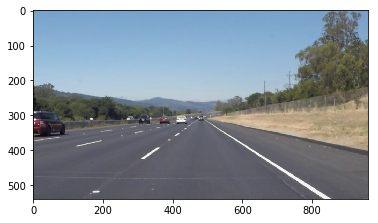

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [18]:
import math

def grayscale(img):
    """
    Objective: 
        Applies the Grayscale transform and return an image with only one color channel
    Inputs: 
        img: image with RGB color
    Outputs:
        A gray image
    NOTE: 
        to see the returned image as grayscale (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """
    Objective: 
        Applies the Canny transform -- detect strong edge (strong gradient) pixels above the high_threshold, 
        and reject pixels below the low_threshold; pixels with values between the low_threshold and high_threshold will
        be included as long as they are connected to strong edges
    Inputs: 
        img: image to be processed
        low_threshold: threshold value range from 0 to 255
        high_threshold: threshold value range from 0 to 255
    Outputs:
        output edges is a binary image with white pixels tracing out the detected edges and black everywhere else
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """
    Objective: 
        Applies a Gaussian Noise kernel -- a way of suppressing noise and spurious gradients by averaging
    Inputs:
        img: image to be processed
        kernel_size: Must be an odd number (3, 5, 7...). 
            A larger kernel_size implies averaging, or smoothing, over a larger area.
    Outputs:
        A smoothed image
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Objective:
        Applies an image mask. Only keeps the region of the image defined by the polygon 
        formed from `vertices`. The rest of the image is set to black.
    Inputs:
        img: image to be processed
        vertices: vertices of the polygon
    Outputs:
        masked_image: image masked by the polygon
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    Objective:
        Iterate over the output "lines" and draw lines on a blank image
    Inputs:
        img: a blank image
        lines: lines generated by Hough detection
    Outputs:
        img: an image drawn lines
    NOTE: 
        this is the function you might want to use as a starting point once you want to 
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).  

        Think about things like separating line segments by their 
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of 
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Objective:
        Applies hough on edge detected image
    Inputs:
        img: should be the output of a Canny transform
        rho: distance resolution in pixels of the Hough grid, typical value (1, 2, ...)
        theta: angular resolution in radians of the Hough grid, typical value np.pi/180 * (1, 2, ...)
        threshold: minimum number of votes (intersections in Hough grid cell)
            meaning at least 15 points in image space need to be associated with each line segment
        min_line_len: minimum number of pixels making up a line
        max_line_gap: maximum gap in pixels between connectable line segments
    Outputs:
        line_img: an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    Objective:
        overlap the img from the hough transformation to the initial_img with some weights
    Inputs:
        `img`: the output of the hough_lines(), An image with lines drawn on it.
            Should be a blank image (all black) with lines drawn on it.
        `initial_img`: should be the image before any processing.
    Outputs:
        The result image is computed as follows:
        initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def line_xy2mb(x1, y1, x2, y2):
    """
    Objective:
        Get the slope and intercept of a line
    Inputs:
        x1: x axis of the first point
        y1: y axis of the first point
        x2: x axis of the second point
        y2: y axis of the second point
    Outputs:
        m: slope
        b: intercept
        d: distance between the two points
    """
    if x1 == x2:
        m = 0
        b = 0
        d = 0
    else:
        m = (y2 - y1) * 1.0 / (x2 - x1)
        b = (y1 * x2 - y2 * x1) * 1.0 / (x2 - x1)
        d = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    return m, b, d

def lines_average(lines, bool_left_right):
    """
    objective:
        Get an average line based on a set of obtained lines
    Inputs:
        lines: a list of detected lines
        bool_left_right: bool variable indicating the input lines are left lines (True) or right lines (False)
    Outputs:
        line_avg: an average line parameterized by slope--m and intercept--b
    """
    
    if lines is None:
        return None
    
    list_lines_mb = list()
    list_lines_d = list()
    
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2: # vertical line
                continue
            else:
                m, b, d = line_xy2mb(x1, y1, x2, y2)
                if bool_left_right == True: # indicating left lines
                    if m < 0: # only include the negative slopes
                        list_lines_mb.append((m,b))
                        list_lines_d.append(d)
                else: # indicating right lines
                    if m > 0: # only include the positive slopes
                        list_lines_mb.append((m,b))
                        list_lines_d.append(d)
                        
    if len(list_lines_d) > 0:
        line_avg = np.dot(list_lines_d, list_lines_mb) / np.sum(list_lines_d)
        return line_avg
    else:
        return None

    
def line_extrapolate(line_mb, y1, y2):
    """
    objective:
        Generate a line based on slope and intercept
    Inputs:
        line_mb: a line parameterized by slope and intercept
        y1: y value of the first point
        y2: y value of the second point
    Outputs:
        line_xy: a line parameterized by x1, y1 and x2, y2
    """
    if line_mb is None:
        return None
    
    m, b = line_mb
    if m == 0:
        return None
    else:
        x1 = int((y1 - b) * 1.0 / m)
        x2 = int((y2 - b) * 1.0 / m)
        y1 = int(y1)
        y2 = int(y2)
        line_xy = [[[x1, y1, x2, y2]]]
        return line_xy
    
def hough_lines_average(img_left, img_right, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Objective:
        Applies hough on edge detected image
    Inputs:
        img_left: should be the output of a Canny transform
        img_right: should be the output of a Canny transform
        rho: distance resolution in pixels of the Hough grid, typical value (1, 2, ...)
        theta: angular resolution in radians of the Hough grid, typical value np.pi/180 * (1, 2, ...)
        threshold: minimum number of votes (intersections in Hough grid cell)
            meaning at least 15 points in image space need to be associated with each line segment
        min_line_len: minimum number of pixels making up a line
        max_line_gap: maximum gap in pixels between connectable line segments
    Outputs:
        line_img: an image with hough lines drawn.
    """
    lines_left = cv2.HoughLinesP(img_left, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_right = cv2.HoughLinesP(img_right, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    """
    line_left_mb = lines_average(lines = lines_left, bool_left_right = True)
    #print(line_left_mb)
    line_right_mb = lines_average(lines = lines_right, bool_left_right = False)
    #print(line_right_mb)
    
    
    imshape = img_left.shape
    y1 = 1.0*imshape[0]
    y2 = 0.6*imshape[0]
    line_left_xy = line_extrapolate(line_mb = line_left_mb, y1 = y1, y2 = y2)
    #print(line_left_xy)
    line_right_xy = line_extrapolate(line_mb = line_right_mb, y1 = y1, y2 = y2)
    #print(line_right_xy)
    
    #concatenate left lines and right lines together
    if (line_left_xy is not None) and (line_right_xy is not None):
        lines = np.concatenate((line_left_xy, line_right_xy))
        line_img = np.zeros((img_left.shape[0], img_left.shape[1], 3), dtype=np.uint8)
        draw_lines(line_img, lines)
    elif (line_left_xy is None) and (line_right_xy is not None):
        lines = line_right_xy
        line_img = np.zeros((img_left.shape[0], img_left.shape[1], 3), dtype=np.uint8)
        draw_lines(line_img, lines)
    elif (line_left_xy is not None) and (line_right_xy is None):
        lines = line_left_xy
        line_img = np.zeros((img_left.shape[0], img_left.shape[1], 3), dtype=np.uint8)
        draw_lines(line_img, lines)
    else:
        line_img = np.zeros((img_left.shape[0], img_left.shape[1], 3), dtype=np.uint8)
    """
    lines = np.concatenate((lines_left, lines_right))
    line_img = np.zeros((img_left.shape[0], img_left.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

['solidWhiteCurve.jpg']


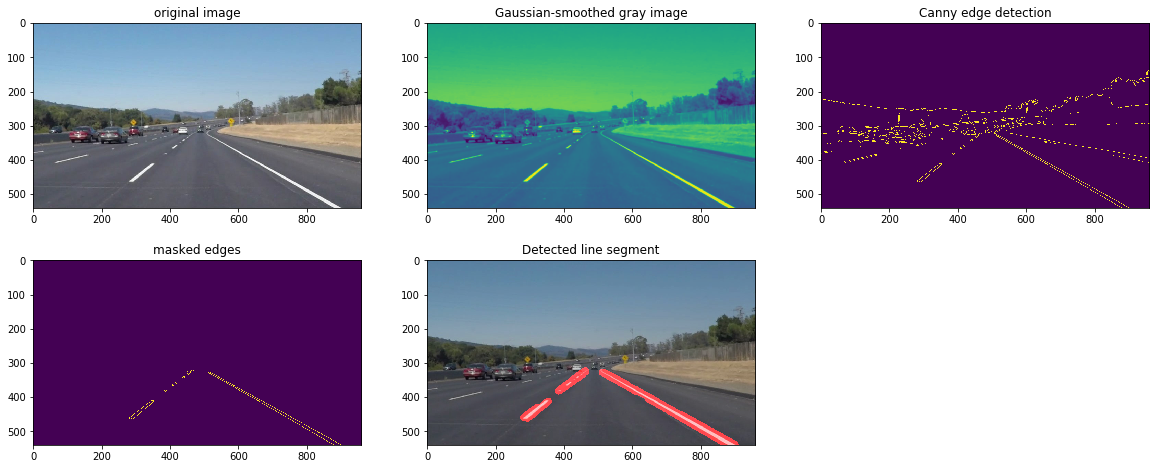

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

debug_mode = 1  # 1 - debug mode, plot figure step by step; 
                # 0 - normal mode, output processed images to the test_images_output directory

input_dir = "test_images/"
output_dir = "test_images_output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# check all of the image that needed to be processed
if debug_mode == 1:
    img_list = ['solidWhiteCurve.jpg']
    print(img_list)
else:
    img_list = os.listdir(input_dir)

# main part for image processing
for img_name in img_list:
    
    image = mpimg.imread(input_dir + img_name)
    
    # create a figure to show the processing of the image process
    if debug_mode == 1:
        plt.gcf().clear()
        fig = plt.figure(figsize = (20, 8))
        fig.add_subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('original image')
        
    # convert the RGB image to grayscale image
    gray_image = grayscale(img = image)
    #if debug_mode == 1:
    #    fig.add_subplot(2, 3, 2)
    #    plt.imshow(gray_image)
    #    plt.title('gray image')
        
    # apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(img = gray_image, kernel_size = kernel_size)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 2)
        plt.imshow(blur_gray_image)
        plt.title('Gaussian-smoothed gray image')  
        
    # apply canny edge detetion to generate an edge image
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(img = blur_gray_image, low_threshold = low_threshold, high_threshold = high_threshold)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 3)
        plt.imshow(edge_image)
        plt.title('Canny edge detection')    
        
    # mask the image with a four side polygon
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(460, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edge_image = region_of_interest(img = edge_image, vertices = vertices)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 4)
        plt.imshow(masked_edge_image)
        plt.title('masked edges') 
    
    # apply Hough line tranformation
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    line_image = hough_lines(img = masked_edge_image, 
                             rho = rho, 
                             theta = theta, 
                             threshold =  threshold, 
                             min_line_len = min_line_length, 
                             max_line_gap = max_line_gap)
    
    # combine the line image with the edge image
    lines_edges = weighted_img(img = line_image, initial_img = image)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 5)
        plt.imshow(lines_edges)
        plt.title('Detected line segment') 
    
    

solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


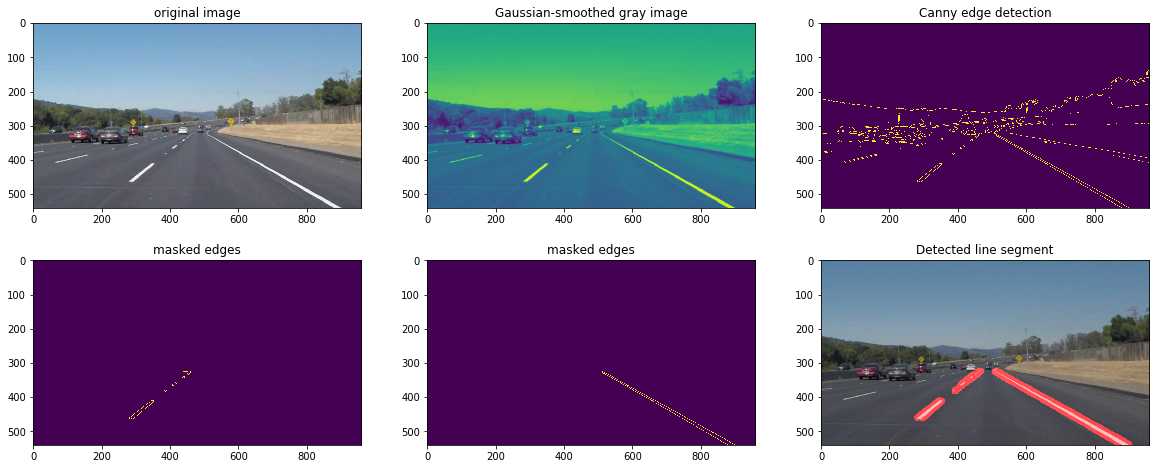

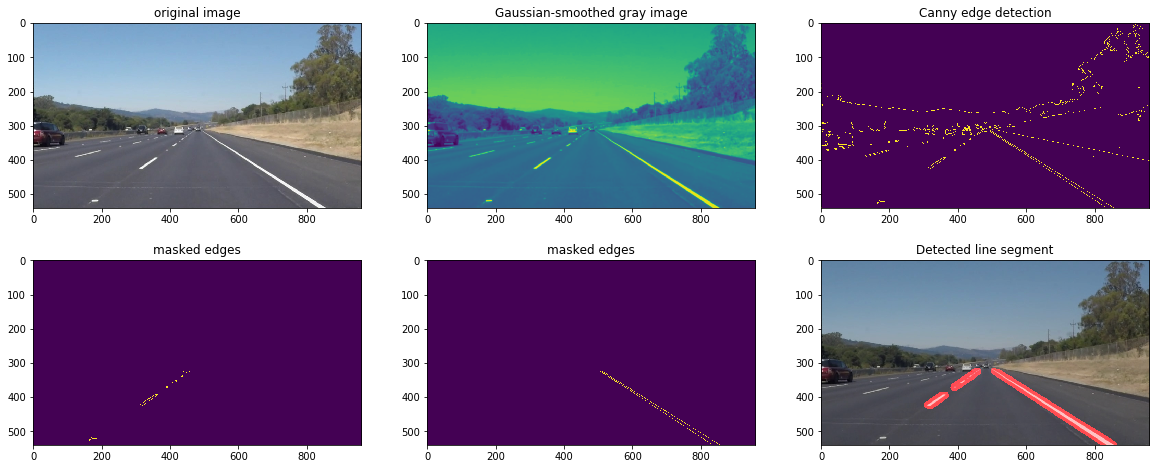

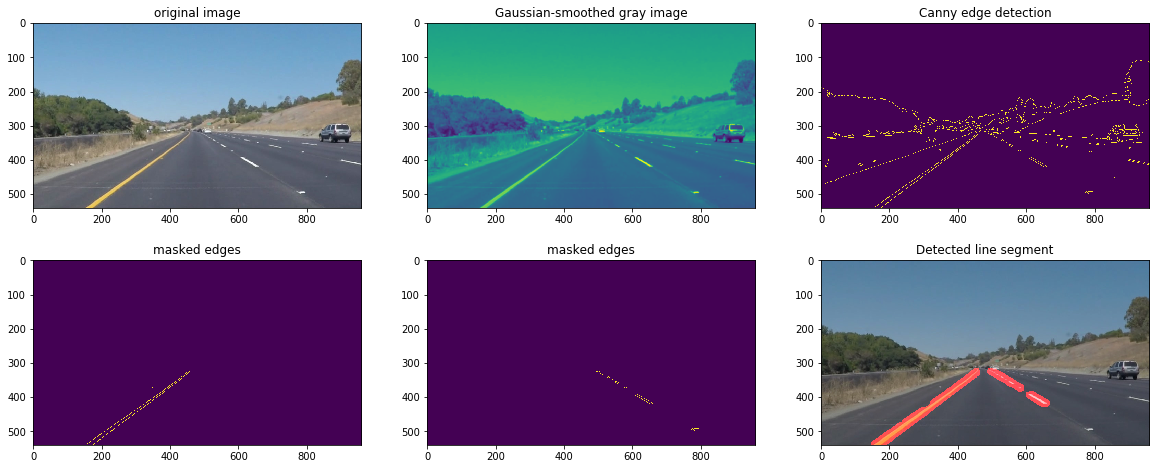

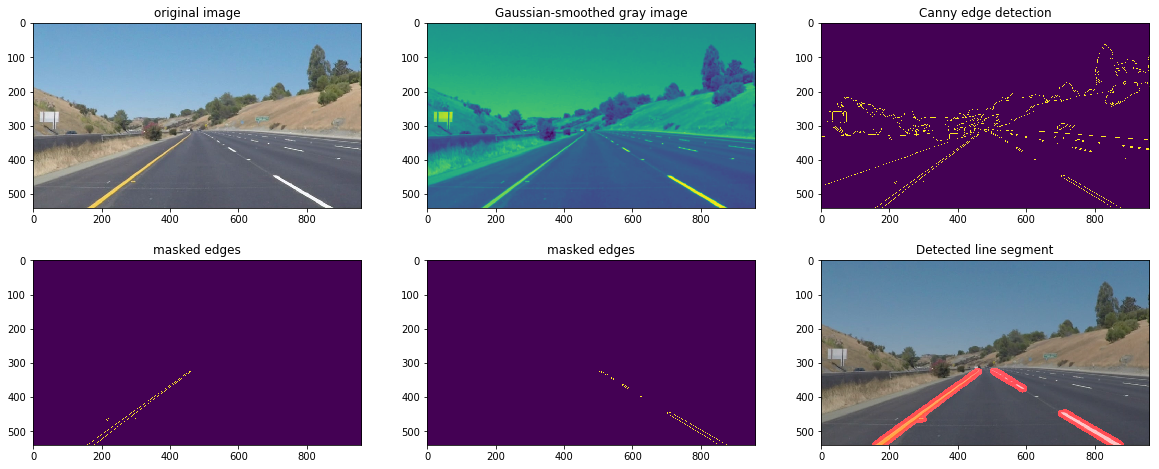

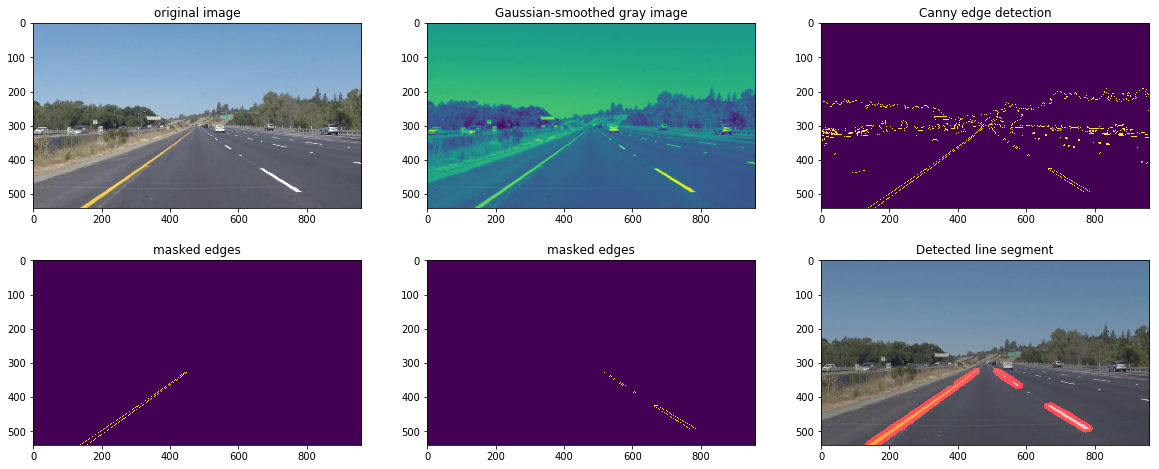

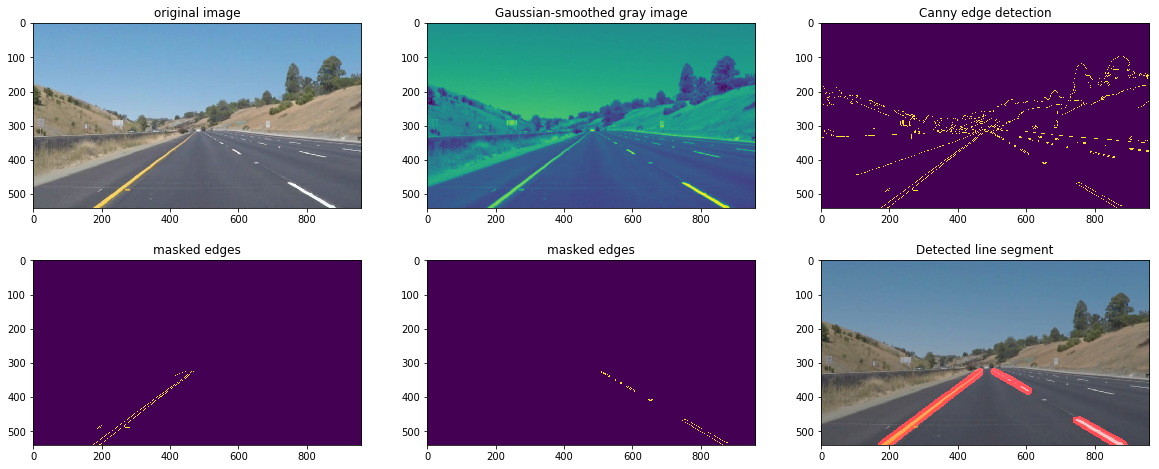

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

debug_mode = 1  # 1 - debug mode, plot figure step by step; 
                # 0 - normal mode, output processed images to the test_images_output directory

input_dir = "test_images/"
output_dir = "test_images_output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# check all of the image that needed to be processed
if debug_mode == 1:
    plt.gcf().clear()
    #img_list = ["solidWhiteCurve.jpg"]
    img_list = os.listdir(input_dir)
    #print(img_list)
else:
    img_list = os.listdir(input_dir)

# main part for image processing
for img_name in img_list:
    
    image = mpimg.imread(input_dir + img_name)
    
    # create a figure to show the processing of the image process
    if debug_mode == 1:
        print(img_name)
        fig = plt.figure(figsize = (20, 8))
        fig.add_subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('original image')
        
    # convert the RGB image to grayscale image
    gray_image = grayscale(img = image)
    #if debug_mode == 1:
    #    fig.add_subplot(2, 3, 2)
    #    plt.imshow(gray_image)
    #    plt.title('gray image')
        
    # apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(img = gray_image, kernel_size = kernel_size)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 2)
        plt.imshow(blur_gray_image)
        plt.title('Gaussian-smoothed gray image')  
        
    # apply canny edge detetion to generate an edge image
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(img = blur_gray_image, low_threshold = low_threshold, high_threshold = high_threshold)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 3)
        plt.imshow(edge_image)
        plt.title('Canny edge detection')    
        
    # mask the image with a four side polygon
    imshape = image.shape
    bottom_left = [round(0*imshape[1]), round(1.0*imshape[0])]
    bottom_middle = [round(0.5*imshape[1]), round(1.0*imshape[0])]
    bottom_right = [round(1.0*imshape[1]), round(1.0*imshape[0])]
    top_left = [round(0.46*imshape[1]), round(0.6*imshape[0])]
    top_middle = [round(0.5*imshape[1]), round(0.6*imshape[0])]
    top_right = [round(0.54*imshape[1]), round(0.6*imshape[0])]
    #vertices_left = np.array([[(0,imshape[0]), (460, 320), (480, 320), (480,imshape[0])]], dtype=np.int32)
    vertices_left = np.array([[bottom_left, top_left, top_middle, bottom_middle]], dtype=np.int32)
    masked_edge_image_left = region_of_interest(img = edge_image, vertices = vertices_left)
    
    #vertices_right = np.array([[(480,imshape[0]), (480, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices_right = np.array([[bottom_middle, top_middle, top_right, bottom_right]], dtype=np.int32)
    masked_edge_image_right = region_of_interest(img = edge_image, vertices = vertices_right)
    
    if debug_mode == 1:
        fig.add_subplot(2, 3, 4)
        plt.imshow(masked_edge_image_left)
        plt.title('masked edges') 
        
        fig.add_subplot(2, 3, 5)
        plt.imshow(masked_edge_image_right)
        plt.title('masked edges') 
    
    # apply Hough line tranformation
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    line_image = hough_lines_average(img_left = masked_edge_image_left,
                                     img_right = masked_edge_image_right,
                             rho = rho, 
                             theta = theta, 
                             threshold =  threshold, 
                             min_line_len = min_line_length, 
                             max_line_gap = max_line_gap)
    
    # combine the line image with the edge image
    lines_edges = weighted_img(img = line_image, initial_img = image)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 6)
        plt.imshow(lines_edges)
        plt.title('Detected line segment') 
    else:
        mpimg.imsave(arr = lines_edges, fname = output_dir+img_name)
    

To average/extrapolate the detected line segments, we will adopt the following approaches:

#### A. divde the original mask zone into the left mask zone and the right mask zone. 
This has several advantages:
1. It is easier for us to detect the left lines and the right lines with Hough tranformation.
2. It is easier to calculate the average of the detected line segments.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

1. To **install moviepy**, you can run 
```
pip install moviepy
```
in the command window.
2. To get rid of the **NeedDownloadError: Need ffmpeg exe**. You can download it by calling:
```python
import imageio
imageio.plugins.ffmpeg.download()
```

In [7]:
##import imageio
##imageio.plugins.ffmpeg.download()

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image, debug_mode = 0):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # create a figure to show the processing of the image process
    if debug_mode == 1:
        print(img_name)
        fig = plt.figure(figsize = (20, 8))
        fig.add_subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('original image')
        
    # convert the RGB image to grayscale image
    gray_image = grayscale(img = image)
    #if debug_mode == 1:
    #    fig.add_subplot(2, 3, 2)
    #    plt.imshow(gray_image)
    #    plt.title('gray image')
        
    # apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(img = gray_image, kernel_size = kernel_size)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 2)
        plt.imshow(blur_gray_image)
        plt.title('Gaussian-smoothed gray image')  
        
    # apply canny edge detetion to generate an edge image
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(img = blur_gray_image, low_threshold = low_threshold, high_threshold = high_threshold)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 3)
        plt.imshow(edge_image)
        plt.title('Canny edge detection')    
        
    # mask the image with a four side polygon
    imshape = image.shape
    bottom_left = [round(0*imshape[1]), round(1.0*imshape[0])]
    bottom_middle = [round(0.5*imshape[1]), round(1.0*imshape[0])]
    bottom_right = [round(1.0*imshape[1]), round(1.0*imshape[0])]
    top_left = [round(0.46*imshape[1]), round(0.6*imshape[0])]
    top_middle = [round(0.5*imshape[1]), round(0.6*imshape[0])]
    top_right = [round(0.54*imshape[1]), round(0.6*imshape[0])]
    #vertices_left = np.array([[(0,imshape[0]), (460, 320), (480, 320), (480,imshape[0])]], dtype=np.int32)
    vertices_left = np.array([[bottom_left, top_left, top_middle, bottom_middle]], dtype=np.int32)
    masked_edge_image_left = region_of_interest(img = edge_image, vertices = vertices_left)
    
    #vertices_right = np.array([[(480,imshape[0]), (480, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices_right = np.array([[bottom_middle, top_middle, top_right, bottom_right]], dtype=np.int32)
    masked_edge_image_right = region_of_interest(img = edge_image, vertices = vertices_right)
    
    if debug_mode == 1:
        fig.add_subplot(2, 3, 4)
        plt.imshow(masked_edge_image_left)
        plt.title('masked edges') 
        
        fig.add_subplot(2, 3, 5)
        plt.imshow(masked_edge_image_right)
        plt.title('masked edges') 
    
    # apply Hough line tranformation
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    line_image = hough_lines_average(img_left = masked_edge_image_left,
                                     img_right = masked_edge_image_right,
                             rho = rho, 
                             theta = theta, 
                             threshold =  threshold, 
                             min_line_len = min_line_length, 
                             max_line_gap = max_line_gap)
    
    # combine the line image with the edge image
    lines_edges = weighted_img(img = line_image, initial_img = image)
    if debug_mode == 1:
        fig.add_subplot(2, 3, 6)
        plt.imshow(lines_edges)
        plt.title('Detected line segment') 
        
    result = lines_edges
    
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
output_dir = "test_videos_output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [23]:
white_output = output_dir + 'solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_images_output/solidWhiteRight.mp4
[MoviePy] Writing video test_images_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 32.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_images_output/solidWhiteRight.mp4 

Wall time: 7.72 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:21<00:00, 30.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 22.8 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:15<00:00, 15.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 17.8 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))